<a href="https://colab.research.google.com/github/Maziger/master-reinforcement-learning/blob/main/Notebooks/08_dynamic_programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Notebook pre steps

# ALWAYS SAVE YOUR OWN COPY OF THIS NOTEBOOK: File > Save a copy in Drive
# IF DANISH MENU DO: Hjælp > Engelsk version

# To clear output do: Edit > Clear all outputs

## Useful shortscuts
# Run current cell: Cmd+Enter
# Run current cell and goto next: Shift+Enter
# Run selection (or line if no selection): Cmd+Shift+Enter

# install missing packages
!pip install pymdptoolbox
!pip install dfply

import numpy as np
import pandas as pd

  Preparing metadata (setup.py) ... done
  Created wheel for pymdptoolbox: filename=pymdptoolbox-4.0b3-py3-none-any.whl size=25655 sha256=542300f6736ad859b12da2fd01190c019c2da649c48b647015edb64d43e379e6
  Stored in directory: /root/.cache/pip/wheels/0b/4b/f1/7221d3bb66b4076e94c39d7957b19f41253305a5a823699a01
Successfully built pymdptoolbox
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.4/612.4 kB 18.3 MB/s eta 0:00:00


# Dynamic programming

This notebook considers dynamic programming algorithms. The term *Dynamic Programming* (*DP*) refers to a collection of algorithms that can be used to compute optimal policies of a model with full information about the dynamics, e.g. a Markov Decision Process (MDP).

There are many ways to represent an MDP. First, we implement the algorithm by having

*  A list `p_mat` which contains a matrix for each action, e.g. `p_mat[a]` is a the transition probabilities for doing action with index a, i.e. `p_mat[a][s, s'] is the transition probability $p(s'|a,s)$.
* A matrix `r_mat` such that `r_mat[s, a]` equals $r(s,a)$.

Note this imply that we assume that all states can take all actions. If a state has illigal actions, then set the transition probability to the same state to 1. Moreover, set the reward $r(s,a)$ to a large negative number, so the action not will be choosen as optimal.

## Example - Factory Storage

Let us consider [Exercise 6.6.4](https://bss-osca.github.io/rl/06_mdp-1.html#sec-mdp-1-storage) where a factory has a storage tank with a capacity of 4 $\mathrm{m}^{3}$ for temporarily storing waste produced by the factory. Each week the factory produces $0,1$, 2 or 3 $\mathrm{m}^{3}$ waste with respective probabilities
$$p_{0}=\displaystyle \frac{1}{8},\ p_{1}=\displaystyle \frac{1}{2},\ p_{2}=\displaystyle \frac{1}{4} \text{ and } p_{3}=\displaystyle \frac{1}{8}.$$
If the amount of waste produced in one week exceeds the remaining capacity of the tank, the excess is specially removed at a cost of \$30 per cubic metre. At the end of each week there is a regular opportunity to remove all waste from the storage tank at a fixed cost of \$25 and a variable cost of \$5 per cubic metre.

The problem can be modelled as a finite MDP where a state denote the amount of waste in the tank at the end of week $n$ just before the regular removal opportunity $$S = \{ 0,1,2,3,4 \}.$$
The action space is $$A(s) = \{ empty (e), keep (k) \}.$$
The expected cost of a given state and action is the cost of empting the container and the expected cost of a special removal during the next week. Hence the expected reward is $$r(s, e) = -(25 + 5s)$$
and $$r(s,k) = -30\sum_{i>4-s} (s+i-4)p_i.$$
Finally, the transition probabilities are:
$$
\begin{align}
   p(s'|s,k) &= p_{s'-s}\text{ if } s\leq s' \leq 3, \\
   p(4|s,k)  &= \sum_{i\geq 4-s} p_i, \\
   p(s'|s,e) &= p_{s'}\text{ if }  0\leq s' \leq 4, \\
   p(s'|s,a) &=  0 \text{ otherwise.}
\end{align}
$$

First we add transition probabilities and reward to a list and matrix so in the format needed for the DP algorithms.

In [ ]:
# Constants
NUM_STATES = 5       # Tank levels: 0 to 4
NUM_ACTIONS = 2      # Actions: 0 = keep, 1 = empty

# Waste generation probabilities for 0–3 m³
waste_probs = [1/8, 1/2, 1/4, 1/8]
MAX_WASTE = 3        # Max production in one week

# Initialize transition probability matrices for each action
p_mat = [np.zeros((NUM_STATES, NUM_STATES)) for _ in range(NUM_ACTIONS)]

# Initialize reward matrix: rows = states, columns = actions
r_mat = np.zeros((NUM_STATES, NUM_ACTIONS))

# Action 0: keep
# Accumulate overflow costs based on possible next waste productions
for s in range(NUM_STATES):
    expected_overflow_cost = 0
    for i in range(len(waste_probs)):  # i: waste produced (0–3 m³)
        next_state = s + i
        if next_state <= 4:
            p_mat[0][s, next_state] += waste_probs[i]
        else:
            # Clamp overflowed states to 4, calculate overflow cost
            p_mat[0][s, 4] += waste_probs[i]
            overflow = next_state - 4
            expected_overflow_cost += overflow * 30 * waste_probs[i]
    r_mat[s, 0] = -expected_overflow_cost  # Reward is negative cost

# Action 1: empty
# Transition probabilities are based only on new waste produced
# Tank is reset to empty before production
for s in range(NUM_STATES):
    for i in range(len(waste_probs)):
        p_mat[1][s, i] = waste_probs[i]  # Transition to state i
    r_mat[s, 1] = -(25 + 5 * s)  # Cost of emptying tank

# Output results using data frames
state_labels = [f"s{i}" for i in range(NUM_STATES)]
action_labels = ["keep", "empty"]

# Display reward matrix
reward_df = pd.DataFrame(r_mat, index=state_labels, columns=action_labels)
print("Reward matrix with labels:")
print(reward_df)

# Display transition matrix for 'keep' action
transition_df = pd.DataFrame(p_mat[0], index=state_labels, columns=state_labels)
print("\nTransition matrix for action 'keep':")
print(transition_df)

# Display transition matrix for 'empty' action
transition_df = pd.DataFrame(p_mat[1], index=state_labels, columns=state_labels)
print("\nTransition matrix for action 'empty':")
print(transition_df)

Reward matrix with labels:
     keep  empty
s0   0.00  -25.0
s1   0.00  -30.0
s2  -3.75  -35.0
s3 -15.00  -40.0
s4 -41.25  -45.0

Transition matrix for action 'keep':
       s0     s1     s2     s3     s4
s0  0.125  0.500  0.250  0.125  0.000
s1  0.000  0.125  0.500  0.250  0.125
s2  0.000  0.000  0.125  0.500  0.375
s3  0.000  0.000  0.000  0.125  0.875
s4  0.000  0.000  0.000  0.000  1.000

Transition matrix for action 'empty':
       s0   s1    s2     s3   s4
s0  0.125  0.5  0.25  0.125  0.0
s1  0.125  0.5  0.25  0.125  0.0
s2  0.125  0.5  0.25  0.125  0.0
s3  0.125  0.5  0.25  0.125  0.0
s4  0.125  0.5  0.25  0.125  0.0


* Choosing in the specific states = s_x, means the amount of money it costs to choose either keep or empty.
  * For instance in state 3, choosing keep costs 3.75$

## Policy evaluation

There are many ways to represent an MDP. Here we implement the algorithm by having

*  A list `p_mat` which contains a matrix for each action, e.g. `p_mat[a]` is a the transition probabilities for doing action with index a, i.e. `p_mat[a][s, s'] is the transition probability $p(s'|a,s)$.
* A matrix `r_mat` such that `r_mat[s, a]` equals $r(s,a)$.

Note this imply that we assume that all states can take all actions. If a state has illigal actions, then set the transition probability to the same state to 1. Moreover, set the reward $r(s,a)$ to a large negative number, so the action not will be choosen as optimal.

In [ ]:
import numpy as np

def policy_evaluation(policy, p_mat, r_mat, gamma=0.5, threshold=1e-5):
    """
    Performs policy evaluation for a given MDP. Note here we identify states and
    actions by their indices (starting from 0).

    Args:
        policy (ndarray): The policy to evaluate.
        p_mat (list): Transition probability matrices for each action.
        r_mat (ndarray): Reward matrix of shape (states, actions).
        gamma (float): Discount factor.
        threshold (float): Convergence threshold.

    Returns:
        V (ndarray): Value function for the given policy.
        iteration (int): Number of iterations until convergence.
    """
    NUM_STATES = r_mat.shape[0]
    NUM_ACTIONS = r_mat.shape[1]
    iteration = 0
    V = np.zeros(NUM_STATES) # current state values

    # Policy evaluation
    while True:
        delta = 0
        for s in range(NUM_STATES):
            v = V[s]
            action = policy[s]
            V[s] = r_mat[s, action] + gamma * np.dot(p_mat[action][s], V)
            delta = max(delta, abs(V[s]-v))
        iteration += 1
        if delta < threshold:
            break

    return V, iteration

### Your turn - Factory Storage

1. Consider the policy never to empty except if the tank contains $1 m^3$.
   - Calculate the total expected discounted cost with a discount rate of 0.99.
   - What is the expected total discounted cost assuming starting with $3m^3$ in the tank?
2. Consider the policy to never empty the tank.
   - Calculate the total expected discounted cost with a discount rate of 0.99.
   - What is the expected total discounted cost assuming starting with $2m^3$ in the tank?
3. Which policy is best if I start with an empty tank? Which is best if start with $1m^3$ in the tank?

In [10]:
#@title Solution

policy1 = (0, 1, 0, 0, 0)
V_pe1, ite1 = policy_evaluation(policy1, p_mat, r_mat, gamma=0.99)
policy2 = (0, 0, 0, 0, 0)
V_pe2, ite2 = policy_evaluation(policy2, p_mat, r_mat, gamma=0.99)

print("\nQ3: Compare policies using a data frame:")
df_result = pd.DataFrame({
    "State": state_labels,
    "V (pe1)": V_pe1,
    "Policy (pe1)": [action_labels[i] for i in policy1],
    "V (pe2)": V_pe2,
    "Policy (pe2)": [action_labels[i] for i in policy2],
})
display(df_result)


Q3: Compare policies using a data frame:


,State,V (pe1),Policy (pe1),V (pe2),Policy (pe2)
0,s0,-4007.260869,keep,-4006.393901,keep
1,s1,-4037.260870,empty,-4035.726161,keep
2,s2,-4065.279965,keep,-4065.279965,keep
3,s3,-4095.041810,keep,-4095.041810,keep
4,s4,-4124.999014,keep,-4124.999014,keep


* What is the expected total discounted cost assuming starting with 3m3 in the tank?
  * s3 = -4095 (for both policy pe1 and pe2) = expected total discounted cost of having 3 cubic meters in the tank is 4095. So it would cost you this amount for 3 cubic meters in the tank, given this policy.
* What is the expected total discounted cost assuming starting with 2m3 in the tank?
  * s2 = -4065 (for both policy pe1 and pe2) = expected total discounted cost of having 2 cubic meters in the tank. So if we start with 2 cubic meters of waste in the tank and follow the optimal policy, we can expect a total discounted cost of approx 4065 dollars over the infinite time horizon.

* Which policy is best if I start with an empty tank? Which is best if start with 1m3 in the tank?
  * If we start with an empty tank there is only a slight difference between the two policies, but pe2 is the better with -4006 compared to -4007. Meaning we get a slightly lower cost. (we maximise the value function by minimising cost)
  * Pe2 is also better with 1 cubic meter in the tank, slightly lower cost.

## Policy iteration

We now extend the policy evaluation algorithm.

In [ ]:
import numpy as np

def policy_iteration(p_mat, r_mat, gamma=0.5, threshold=1e-5):
    """
    Performs policy iteration for a given MDP. Note here we identify states and
    actions by their indices (starting from 0).

    Args:
        p_mat (list): Transition probability matrices for each action.
        r_mat (ndarray): Reward matrix of shape (states, actions).
        gamma (float): Discount factor.
        threshold (float): Convergence threshold.

    Returns:
        V (ndarray): Optimal value function.
        policy (ndarray): Optimal policy.
        iteration (int): Number of iterations until convergence.
    """
    NUM_STATES = r_mat.shape[0]
    NUM_ACTIONS = r_mat.shape[1]
    policy = np.zeros(NUM_STATES, dtype=int)
    is_policy_stable = False
    iteration = 0
    V = np.zeros(NUM_STATES) # current state values

    while not is_policy_stable:
        # Policy evaluation
        while True:
            delta = 0
            for s in range(NUM_STATES):
                v = V[s]
                action = policy[s]
                V[s] = r_mat[s, action] + gamma * np.dot(p_mat[action][s], V)
                delta = max(delta, abs(V[s]-v))
            iteration += 1
            if delta < threshold:
                break

        # Policy improvement
        is_policy_stable = True
        for s in range(NUM_STATES):
            old_action = policy[s]
            action_values = [r_mat[s, a] + gamma * np.dot(p_mat[a][s], V) for a in range(NUM_ACTIONS)]
            policy[s] = int(np.argmax(action_values))
            if old_action != policy[s]:
                is_policy_stable = False
        iteration += 1
    return V, policy, iteration

### Your turn - Factory Storage

1. Run policy iteration using a discount rate of 0.5.
2. What is the optimal policy?

In [ ]:
#@title Solution

# Run Policy Iteration
V_pi, policy_pi, num_iters_pi = policy_iteration(p_mat, r_mat, gamma=0.5)

print("\nPolicy Iteration Results:")
print("Optimal policy (0 = keep, 1 = empty):", policy_pi)
print("Value function:", V_pi)
print("Converged in iterations:", num_iters_pi, "\n")



Policy Iteration Results:
Optimal policy (0 = keep, 1 = empty): [0 0 0 0 1]
Value function: [-10.66265843 -16.32792889 -26.32610815 -41.97590748 -55.66265611]
Converged in iterations: 56 



* Remember the policy_iteration function we defined in the above, we call it now and the three return values V, policy and iterations we assign to 3 separate values so we can see them individually.

* What is the optimal policy?
  * Optimal policy is [0 0 0 0 1]
  * The results show that the optimal policy is to only empty the tank when it is completely full at the last state of 4 cubic meters in the tank. In all other states, keep the waste and accept the risk of potential overflow.
  * The value function represents the expected total discounted cost when starting from each state and following the optimal policy.
  * This solution prioritize avoiding the immediate emptying cost (25$ fixed and 5$ per cubic meter) over preventing potential future overflow costs (30$ per cubic meter)

* It took 56 iterations to find the optimal policy. The process is policy evaluation, policy improvement and repeat until the policy stops changing.

* The discount rate at 0.5 has a significance difference on the results, compared to the previous discount rate at 0.99 (look up why)
  * With a discount rate of 0.5, future costs are worth only 50% of their current value. This develops exponentially with each time period.
  * With a discount rate of 0.99, future costs are weighted almost as heavily as current costs. So here we see the values of more than -4000 is a result of future costs accumulate significantly, because they barely reduce in value with this rate.



## Value iteration

We may implement this in Python by having a set of matrices for the transition probabilities and rewards as when implemented policy iteration (see previous section).

In [ ]:
def value_iteration(p_mat, r_mat, gamma=0.5, threshold=1e-5):
    """
    Performs value iteration for a given MDP.

    Args:
        p_mat (list): Transition probability matrices for each action.
        r_mat (ndarray): Reward matrix of shape (states, actions).
        gamma (float): Discount factor.
        threshold (float): Convergence threshold.

    Returns:
        V (ndarray): Optimal value function.
        policy (ndarray): Optimal policy.
        iteration (int): Number of iterations until convergence.
    """
    NUM_STATES = r_mat.shape[0]
    NUM_ACTIONS = r_mat.shape[1]
    V = np.zeros(NUM_STATES)
    policy = np.zeros(NUM_STATES, dtype=int)
    iteration = 0

    while True:
        delta = 0
        for s in range(NUM_STATES):
            action_values = []
            for a in range(NUM_ACTIONS):
                expected_value = r_mat[s, a] + gamma * np.dot(p_mat[a][s], V)
                action_values.append(expected_value)
            best_value = max(action_values)
            delta = max(delta, abs(best_value - V[s]))
            V[s] = best_value
            policy[s] = int(np.argmax(action_values))
        iteration += 1
        if delta < threshold:
            break
    return V, policy, iteration

### Your turn - Factory Storage

1. Run value iteration using a discount rate of 0.5.
2. Compare the results from value iteration (they should be the same).

In [11]:
#@title Solution

# Run Value Iteration
V_vi, policy_vi, num_iters_vi = value_iteration(p_mat, r_mat, gamma=0.5)

print("\nValue Iteration Results:")
print("Optimal policy (0 = keep, 1 = empty):", policy_vi)
print("Value function:", V_vi)
print("Converged in iterations:", num_iters_vi)

print("Compare results using a data frame:")
df_result = pd.DataFrame({
    "State": state_labels,
    "V (vi)": V_vi.round(4),
    "Policy (vi)": [action_labels[i] for i in policy_vi],
    "V (pi)": V_pi.round(4),
    "Policy (pi)": [action_labels[i] for i in policy_pi],
})
display(df_result)


Value Iteration Results:
Optimal policy (0 = keep, 1 = empty): [0 0 0 0 1]
Value function: [-10.66265239 -16.32792407 -26.32610426 -41.97590432 -55.66265384]
Converged in iterations: 18
Compare results using a data frame:


,State,V (vi),Policy (vi),V (pi),Policy (pi)
0,s0,-10.6627,keep,-10.6627,keep
1,s1,-16.3279,keep,-16.3279,keep
2,s2,-26.3261,keep,-26.3261,keep
3,s3,-41.9759,keep,-41.9759,keep
4,s4,-55.6627,empty,-55.6627,empty


* The results are the same from before
* Policy iteration requires full policy evaluation at each iteration step. This could be an computationally expensive process which requires may sweeps of the state space. In value iteration, the policy evaluation is stopped after one sweep of the state space.
* So essentially both the policy iteration and value iteration solve the same MDP optimally, but we notice that the value iteration is able to solve this fater (18 iterations).

## Using `mdptoolbox` algorithms

There is also a library that already implements policy and value iteration. It must be installed using `pip` (see the pre-steps section).

In [12]:
import mdptoolbox as mdpbox

# Solve using Value Iteration
vi = mdpbox.mdp.ValueIteration(p_mat, r_mat, 0.5)
vi.run()

# Display optimal policy and value function
print("\nOptimal policy (0 = keep, 1 = empty):", vi.policy)
print("Value function:", vi.V)


Optimal policy (0 = keep, 1 = empty): (0, 0, 0, 0, 1)
Value function: (-10.51224522292614, -16.177535941824317, -26.175069459713995, -41.82461469434202, -55.51224522292614)


#### Your turn

1. Solve the problem using policy iteration with a discount rate of 0.5.
2. Solve the problem with a discount rate of 0.99.
  - Is the policy different than when used a discount rate of 0.5?
  - What is the total expected cost if start with an empty tank?
  - Why is it different than when used a discount rate of 0.5?

In [15]:
#@title Solution

# Q1
pi = mdpbox.mdp.PolicyIteration(p_mat, r_mat, 0.5)
pi.run()

# Display optimal policy and value function
print("Q1)\nOptimal policy (gamma = 0.5):", pi.policy)
print("Value function:", pi.V)

# Q2
pi = mdpbox.mdp.PolicyIteration(p_mat, r_mat, 0.99)
pi.run()

# Display optimal policy and value function
print("\nQ2)\nOptimal policy (gamma = 0.99):", pi.policy)
print("Value function:", pi.V)

Q1)
Optimal policy (gamma = 0.5): (0, 0, 0, 0, 1)
Value function: (-10.662654714233708, -16.327925919184565, -26.326105751729155, -41.97590553330906, -55.66265471423371)

Q2)
Optimal policy (gamma = 0.99): (0, 0, 0, 1, 1)
Value function: (-1749.6352341371678, -1761.994297682444, -1775.6094397390264, -1789.635234137168, -1794.635234137168)


* For the case of discount rate at 0.99:
  * Is the policy different than when used a discount rate of 0.5?
    * Yes it is significantly different, with a DR of 0.99, we now empty the tank when it reaches 3 cubic meters.

  * What is the total expected cost if start with an empty tank?
    * First state = 1749 total cost at a discount rate of 0.99


  * Why is it different than when used a discount rate of 0.5?
    * With a discount rate of 0.99, future costs are weighted almost as heavily as current costs. So here we see the higher costs being a result of future costs accumulate significantly, because they barely reduce in value with this rate.


## A generic MDP builder

Often, a state in an MDP consists of a combination of several state variables. For instance, a state $s$ could be defined by $s = (w, p)$ where $w$ is the weather and $p$ is the price. Here, we need a way to identify a state with a given state index. As a result, a generic way of building the MDP is desired. Below, we implement a class for building an MDP where states, actions, and transition probabilities are stored using a directory.

In [16]:
import random
from collections import defaultdict
import numpy as np
import pandas as pd

class MDP:
    """
    A class representing a Markov Decision Process (MDP) using defaultdict structures.

    This implementation includes state management, action specification, transition
    probabilities, rewards, policies, and iterative algorithms for policy and value iteration.
    """

    def __init__(self):
        """
        Initializes an empty MDP with model and state values.
        """
        self.model = defaultdict(lambda: {"pi": None, "actions": defaultdict(dict)})
        self.v = defaultdict(float)

    def add_state_space(self, states):
        """
        Adds states to the MDP.

        Args:
            states (list): List of state identifiers (strings or convertible to strings).
        """
        for state in states:
            _ = self.model[str(state)]
        self.set_state_value()

    def add_action_space(self, state_str, actions):
        """
        Adds actions to a given state. Note you have to update the action
        afterwards using `add_action`.

        Args:
            state_str (str): The state identifier.
            actions (list): List of action identifiers.
        """
        if not isinstance(state_str, str):
            raise ValueError("State is not a sting!")
        if isinstance(actions, str):
            # If it's a string, put it in a list to treat it as a single item
            actions = [actions]
        for action in actions:
            # Initialize the action dictionary with 'pr' and 'r' keys
            self.model[state_str]["actions"][str(action)] = {"pr": {}, "r": None}

    def add_action(self, state_str, action_str, reward, pr):
        """
        Adds a transition action with reward and transition probabilities.

        Args:
            state_str (str): State from which the action is taken.
            action_str (str): Action identifier.
            reward (float): Expected reward for taking the action.
            pr (dict): Transition probabilities as {next_state: probability}.
        """
        ## remove keys with zero trans pr
        keys_to_remove = [key for key, value in pr.items() if value == 0]
        for key in keys_to_remove:
            del pr[key]
        self.model[state_str]["actions"][action_str] = {"r": reward, "pr": pr}

    def check(self, delta = 10*np.spacing(np.float64(1))):
        """
        Performs checks on the built MDP model.

        Verifies that transition probabilities sum to approximately 1.0 for each
        state-action pair and checks for rewards less than the high_neg_reward.
        Prints warnings if any issues are found.

        Args:
            delta (float, optional): Tolerance for the sum of transition probabilities. Defaults to 1e-10.
        """
        ok = True
        # Check if transition pr of an action sum to one
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                absdiff = np.abs(1-pr_sum)
                if absdiff >= delta:
                    print(f"Warning: Transition probabilities for action '{action_label}' in state '{state_label}' do not sum to 1.0. Diff is: {absdiff}")
                    ok = False

        # Check if there are states with no actions
        for state_label, state_content in self.model.items():
            if len(state_content["actions"]) == 0:
                print(f"Warning: State '{state_label}' has no actions.")
                ok = False

        # Check if all action transitions are to a state
        states = list(self.model.keys())
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                if not all(key in self.model for key in action_content['pr'].keys()):
                    print(f"Warning: Action '{action_label}' in state '{state_label}' has a transition to a non-existing state.")
                    ok = False
        if ok:
            print("All checks passed!")


    def normalize(self):
        """
        Normalizes the transition probabilities for each state-action pair.
        """
        for state_label, state_content in self.model.items():
            for action_label, action_content in state_content["actions"].items():
                pr = action_content["pr"]
                pr_sum = np.sum(list(pr.values()))
                for next_state_label, prob in pr.items():
                    pr[next_state_label] = prob / pr_sum
                action_content["pr"] = pr

    def set_state_value(self, states=None, value=0):
        """
        Initializes or updates the value of states.

        Args:
            states (list, optional): List of state identifiers. Defaults to all states.
            value (float, optional): Value to assign. Defaults to 0.
        """
        states = states or list(self.model.keys())
        for state in states:
            self.v[state] = value

    def set_random_deterministic_policy(self):
        """
        Sets a random deterministic policy for each state.
        """
        for state in self.model:
            actions = list(self.model[state]["actions"].keys())
            if actions:
                chosen_action = random.choice(actions)
                self.model[state]["pi"] = {chosen_action: 1}

    def set_deterministic_policy(self, state_actions):
        """
        Sets a deterministic policy from a state-action mapping.

        Args:
            state_actions (dict): Mapping {state: action}.
        """
        for state, action in state_actions.items():
            self.model[state]["pi"] = {action: 1}

    def set_policy(self, states, pi):
        """
        Sets a stochastic or deterministic policy for a list of states.

        Args:
            states (list): List of states to assign the policy.
            pi (dict): Policy as {action: probability}.
        """
        for state in states:
            self.model[state]["pi"] = pi.copy()

    def get_state_keys(self):
        """
        Returns the list of state identifiers.

        Returns:
            list: List of state keys.
        """
        return list(self.model.keys())

    def get_action_keys(self, state):
        """
        Returns the action identifiers for a given state.

        Args:
            state (str): State identifier.

        Returns:
            list: List of action keys.
        """
        return list(self.model[state]["actions"].keys())

    def get_action_info(self, state):
        """
        Gets reward and transition probabilities for each action in a state.

        Args:
            state (str): State identifier.

        Returns:
            dict: Action information.
        """
        return dict(self.model[state]["actions"])

    def get_mdp_info(self):
        """
        Returns information about the MDP.

        Returns:
            dict: The info.
        """
        res = {}
        res["states"] = len(self.model)
        res["actions"] = sum([len(self.model[k]["actions"]) for k in self.model.keys()])
        return res

    def get_policy(self, add_state_values = False):
        """
        Retrieves the current policy.

        Returns:
            pd.DataFrame: Table of state, action, and probability.
        """
        policy = []
        for state in self.get_state_keys():
            for action, prob in self.model[state]["pi"].items():
                if not add_state_values:
                    policy.append({"state": state, "action": action, "pr": prob})
                else:
                    policy.append({"state": state, "action": action, "pr": prob, "v": self.v[state]})
        df = pd.DataFrame(policy)
        df.set_index("state")
        return df

    def get_state_values(self, states=None):
        """
        Returns the current value of each state.

        Args:
            states (list, optional): Subset of states. Defaults to all.

        Returns:
            pd.DataFrame: Table of state values.
        """
        states = states or list(self.v.keys())
        return pd.DataFrame([{"state": s, "v": self.v[s]} for s in states])

    def get_mdp_matrices(self, high_neg_reward = -100000):
        """
        Returns transition probability and reward matrices.

        Returns:
            tuple: A tuple containing:
                p_mat (list): List of transition probability matrices.
                r_mat (ndarray): Reward matrix.
                states (list): List of state identifiers.
                actions (list): List of action identifiers.
        """
        states = self.get_state_keys()
        actions = set(
            action for state in states for action in self.get_action_keys(state)
        )
        actions = list(actions)
        actions.sort()
        p_mat = [pd.DataFrame(0.0, index=states, columns=states) for _ in actions]
        for df in p_mat:
            np.fill_diagonal(df.values, 1) # set default to transition to same state (so illigal actions work)
        r_mat = pd.DataFrame(high_neg_reward, index=states, columns=actions)
        for state in states:
            for action in self.get_action_keys(state):
                p_mat[actions.index(action)].at[state, state] = 0  # reset to 0 again (since action is not illigal)
                pr = self.model[state]["actions"][action]["pr"]
                r = self.model[state]["actions"][action]["r"]
                r_mat.at[state, action] = r
                for next_state, prob in pr.items():
                    p_mat[actions.index(action)].at[state, next_state] = prob
        p_mat = [m.to_numpy() for m in p_mat]  # convert to matrices
        r_mat = r_mat.to_numpy()
        return p_mat, r_mat, states, actions

    def bellman_calc(self, gamma, state, action):
        """
        Computes Bellman update for a given state-action pair.

        Args:
            gamma (float): Discount factor.
            state (str): State identifier.
            action (str): Action identifier.

        Returns:
            float: Updated value.
        """
        pr = self.model[state]["actions"][action]["pr"]
        reward = self.model[state]["actions"][action]["r"]
        return reward + gamma * sum(pr[s] * self.v[s] for s in pr)

    def policy_eval(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Iteratively evaluates the current policy.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max iterations.
            reset (bool): Whether to reset state values to 0.
        """
        if reset:
            self.set_state_value()
        for _ in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                pi = self.model[state]["pi"]
                value = sum(pi[a] * self.bellman_calc(gamma, state, a) for a in pi)
                self.v[state] = value
                delta = max(delta, abs(v_old - value))
            if delta < theta:
                break
        else:
            print(f"Policy evaluation stopped at max iterations: {max_iter}")

    def policy_iteration(self, gamma, theta=1e-5, max_iter_eval=10000, max_iter_policy=100):
        """
        Performs policy iteration with evaluation and improvement steps.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter_eval (int): Max iterations during policy evaluation.
            max_iter_policy (int): Max policy improvement steps.
        """
        self.set_random_deterministic_policy()
        for i in range(max_iter_policy):
            self.policy_eval(gamma, theta, max_iter_eval, reset=False)
            stable = True
            for state in self.model:
                old_action = next(iter(self.model[state]["pi"]))
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.model[state]["pi"] = {best_action: 1}
                if best_action != old_action:
                    stable = False
            if stable:
                break
        else:
            print(f"Policy iteration stopped at max iterations: {max_iter_policy}")
        print(f"Policy iteration finished in {i + 1} iterations.")

    def value_iteration(self, gamma, theta=1e-5, max_iter=10000, reset=True):
        """
        Performs value iteration algorithm.

        Args:
            gamma (float): Discount factor.
            theta (float): Convergence threshold.
            max_iter (int): Max number of iterations.
            reset (bool): Whether to reinitialize state values.
        """
        self.set_random_deterministic_policy()
        if reset:
            self.set_state_value()
        for i in range(max_iter):
            delta = 0
            for state in self.model:
                v_old = self.v[state]
                best_val, best_action = float("-inf"), None
                for action in self.get_action_keys(state):
                    val = self.bellman_calc(gamma, state, action)
                    if val > best_val:
                        best_val = val
                        best_action = action
                self.v[state] = best_val
                self.model[state]["pi"] = {best_action: 1}
                delta = max(delta, abs(v_old - best_val))
            if delta < theta:
                break
        else:
            print(f"Value iteration stopped at max iterations: {max_iter}")
        print(f"Value iteration finished in {i + 1} iterations.")

Let us test the class:

In [19]:
import pprint as pp

## Testing
state_labels = ["a", "b", "c"]
mdp = MDP()
mdp.add_state_space(state_labels)
mdp.get_state_keys()
mdp.get_action_keys("b")
mdp.add_action("b", "keep", 5, {"a": 0.5, "c": 0.5})
mdp.add_action("b", "empty", 2, {"a": 1})
# mdp.add_action("a", "empty", 2, {"d": 1})
print(mdp.get_action_info("b"))
print(mdp.get_mdp_info())
mdp.check()
pp.pprint(mdp.model)  # internal representation of the dasd MDP
print("Matrices:")
mdp.get_mdp_matrices() # if want to get matrices for mdptoolbox

{'keep': {'r': 5, 'pr': {'a': 0.5, 'c': 0.5}}, 'empty': {'r': 2, 'pr': {'a': 1}}}
{'states': 3, 'actions': 2}
defaultdict(<function MDP.__init__.<locals>.<lambda> at 0x7d86bf66ba60>,
            {'a': {'actions': defaultdict(<class 'dict'>, {}), 'pi': None},
             'b': {'actions': defaultdict(<class 'dict'>,
                                          {'empty': {'pr': {'a': 1}, 'r': 2},
                                           'keep': {'pr': {'a': 0.5, 'c': 0.5},
                                                    'r': 5}}),
                   'pi': None},
             'c': {'actions': defaultdict(<class 'dict'>, {}), 'pi': None}})
Matrices:


([array([[1., 0., 0.],
         [1., 0., 0.],
         [0., 0., 1.]]),
  array([[1. , 0. , 0. ],
         [0.5, 0. , 0.5],
         [0. , 0. , 1. ]])],
 array([[-100000, -100000],
        [      2,       5],
        [-100000, -100000]]),
 ['a', 'b', 'c'],
 ['empty', 'keep'])

* 3 states = a, b, c
* How to read mdp-add_action
  * In state b, the action keep, provides the reward 5, with transition probabilities a = 50% and b = 50%
* Notice the warnings: a and c has been provided no actions yet (we haven't programmed it yet)
* We can see the memory of b having the actions we added stored

### Example - Factory Storage (using `MDP` class)

Lets us try to build and solve the model:

In [20]:
state_labels = [f'{l}' for l in range(0,5)]
action_labels = ["keep", "empty"]
mdp = MDP()
mdp.add_state_space(state_labels)

def reward(s_l, a_l):
    """
    Calculates the expected reward for a given state and action in the Factory Storage problem.

    Args:
        s_l (str): The label of the current state (tank level).
        a_l (str): The label of the action taken ("keep" or "empty").

    Returns:
        float: The calculated expected reward.
    """
    s = int(s_l)
    p = np.array([1/8, 1/2, 1/4, 1/8])

    if a_l == "keep":
        if s < 2:
            return 0  # no excess waste
        k = np.arange(4 - s + 1, 4)  # equivalent to (4 - i + 1):3 in R
        return -30 * np.sum((s + k - 4) * p[k])
    elif a_l == "empty":
        return -1 * (25 + 5 * s)
    return None

def transPr(s_l, a_l):
    """
    Calculates the transition probabilities to the next states for a given state and action.

    Args:
        s_l (str): The label of the current state (tank level).
        a_l (str): The label of the action taken ("keep" or "empty").

    Returns:
        dict: A dictionary where keys are the next state labels (strings) and values are the corresponding probabilities.
    """
    s = int(s_l)
    p = np.array([1/8, 1/2, 1/4, 1/8])
    pr = []
    ids = []
    if a_l == "keep":
        if s < 4:
            for j in range(s, 4):
                pr.append(p[j - s])  # equivalent to p[j - i + 1] in R
                ids.append(str(j)) # Convert to string

        if s <= 4:
            pr.append(np.sum(p[4 - s:4]))  # equivalent to sum(p[(4 - i):3 + 1])
            ids.append('4') # Convert to string
    elif a_l == "empty":
        for j in range(4):
            pr.append(p[j])
            ids.append(str(j)) # Convert to string
        pr.append(0.0) # Add probability for state 4
        ids.append('4') # Add state label '4'
    return dict(zip(ids, pr))  # Return the transition probabilities as a dictionary

# Add actions
for s_l in mdp.get_state_keys():
    for a_l in action_labels:
        # print(f"\ns: {s_l} a: {a_l} reward: {reward(s_l, a_l)} trans pr: {transPr(s_l, a_l)}")
        tpr = transPr(s_l, a_l)
        # row_sum = sum(tpr.values())
        # if not np.isclose(row_sum, 1.0):
        #     print(f"Warning: Transition probabilities for action '{a_l}' (index {a_index}) in state {s_l} (index {s_index}) do not sum to 1.0. Row sum is: {row_sum}")
        mdp.add_action(s_l, a_l, reward(s_l, a_l), transPr(s_l, a_l))
mdp.get_mdp_info()
mdp.check()

# Solve using Value Iteration and mdptoolbox
p_mat, r_mat, states, actions = mdp.get_mdp_matrices()
vi = mdpbox.mdp.ValueIteration(p_mat, r_mat, 0.5)
vi.run()

# Display optimal policy and value function
df_result = pd.DataFrame({
    "State": states,
    "Policy": [actions[p] for p in vi.policy],
    "Value": vi.V
})
print("Optimal policy using mdptollbox")
display(df_result)

print("Optimal policy using MDP class algorithm")
mdp.value_iteration(0.5)
mdp.get_policy(add_state_values = True)

All checks passed!
Optimal policy using mdptollbox


/tmp/ipython-input-532928922.py:262: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-3.75' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  r_mat.at[state, action] = r


,State,Policy,Value
0,0,keep,-10.512245
1,1,keep,-16.177536
2,2,keep,-26.175069
3,3,keep,-41.824615
4,4,empty,-55.512245


Optimal policy using MDP class algorithm
Value iteration finished in 18 iterations.


,state,action,pr,v
0,0,keep,1,-10.662652
1,1,keep,1,-16.327924
2,2,keep,1,-26.326104
3,3,keep,1,-41.975904
4,4,empty,1,-55.662654


* Notice that the states are now saved as strings instead of numbers

## Exercises

### Exercise - Gambler's problem

Consider the [gambler's problem](https://bss-osca.github.io/rl/06_mdp-1.html#sec-mdp-1-gambler).

#### Q1

Build the model. Assume that a reward of one only is given if reach the terminal state 100. Hint: This can be modelled by adding a new terminal state 101 representing the game is over. A transition to this state is then done if reach loose or win state. Moreover, the reward is set to 1 if transition from the win state to the terminal state.

In [24]:
#@title Solution (Q1)

def build_gambler_model(ph = 0.4, goal = 100, obj_eq_pr = True):
    terminate = goal + 1  # terminal state
    fail = 0  # Loose all money

    mdp = MDP()
    mdp.add_state_space(range(goal + 2))

    ## Add action labels
    for s_l in mdp.get_state_keys():
        s = int(s_l)
        if s > fail and s < goal: mdp.add_action_space(s_l, range(1, min(s, goal-s) + 1))
        if s == fail:
            mdp.add_action_space(s_l, ["Lose"])
        if s == goal:
            mdp.add_action_space(s_l, ["Win"])
        if s == terminate:
            mdp.add_action_space(s_l, ["Terminate"])

    ## Add trans pr and rewards to actions
    mdp.add_action(str(fail), "Lose", 0, {str(terminate): 1})
    mdp.add_action(str(goal), "Win", 1, {str(terminate): 1})
    mdp.add_action(str(terminate), "Terminate", 0,{str(terminate): 1}) # Added "Terminate" as action label
    for s in range(1, goal): # states 1-99
        s_l = str(s)
        for a_l in mdp.get_action_keys(s_l):
            a = int(a_l)
            pr = {str(s+a): ph, str(s-a): 1-ph}
            if obj_eq_pr:
                mdp.add_action(s_l, a_l, 0, pr)
            else:
                raise NotImplementedError("Not implemented yet")
    mdp.check()
    print("Created MDP:", mdp.get_mdp_info())
    return mdp

mdp = build_gambler_model()

All checks passed!
Created MDP: {'states': 102, 'actions': 2503}


* The 2503 actions represent all possible state-action combinations

#### Q2

- Solve the problem using value iteration with $p_h = 0.4$.
- Plot the state-values given states 1-99 on the x-axis. Use geom_line().
- Plot the policy with states 1-99 on the x-axis and action on the y-axis. Use geom_col(). Your policy may not look like the policy in the book on page 84. Why?
- What is the probability of winning if you start with 52\$?


Value iteration finished in 12 iterations.


,State,Policy,pr,Value
0,0,Lose,1,0.000000
1,1,1,1,0.002065
2,2,2,1,0.005164
3,3,3,1,0.009225
4,4,4,1,0.012910
...,...,...,...,...
97,97,3,1,0.923244
98,98,2,1,0.940555
99,99,1,1,0.964333
100,100,Win,1,1.000000


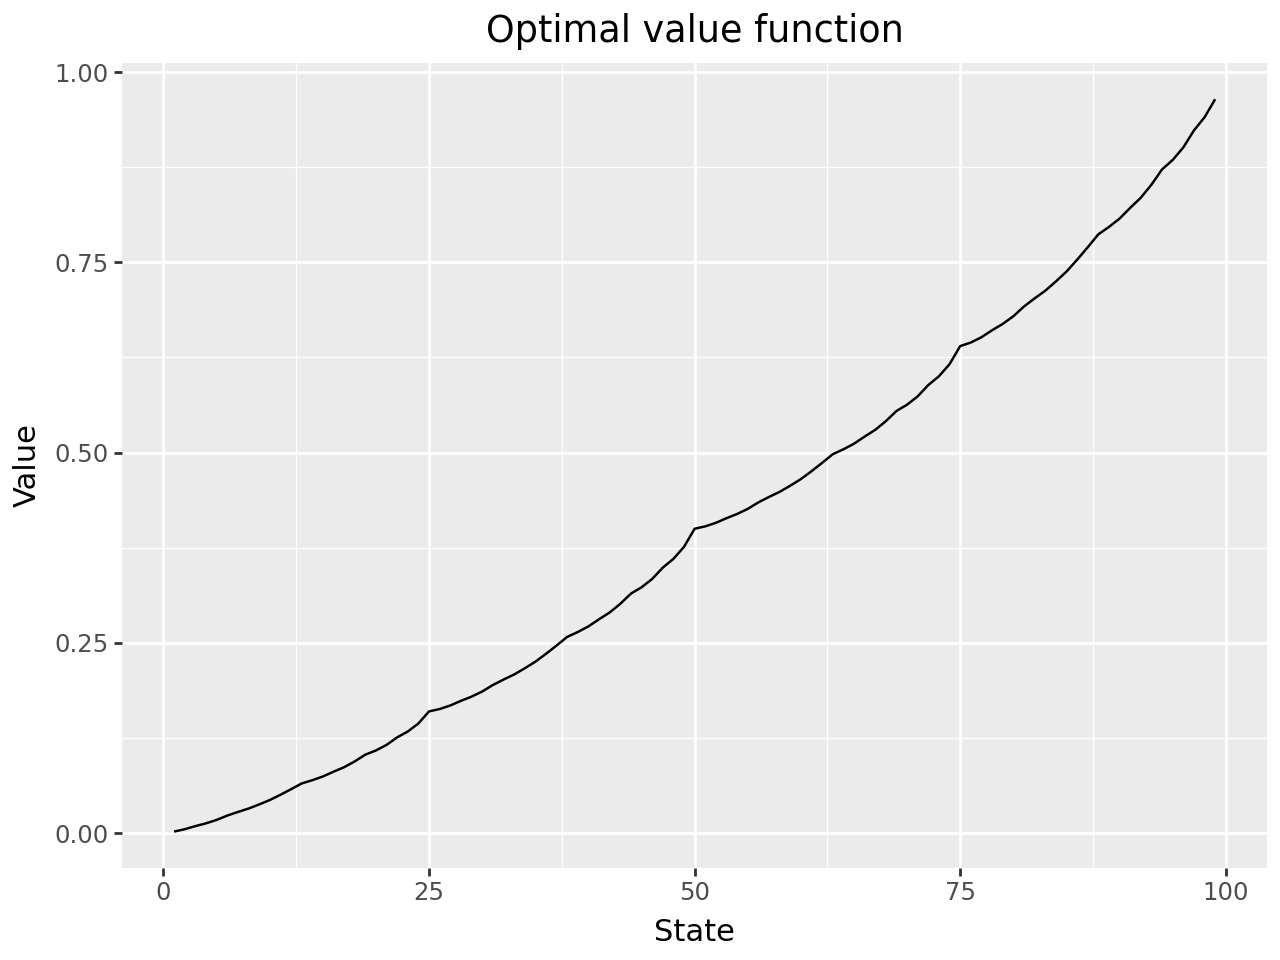

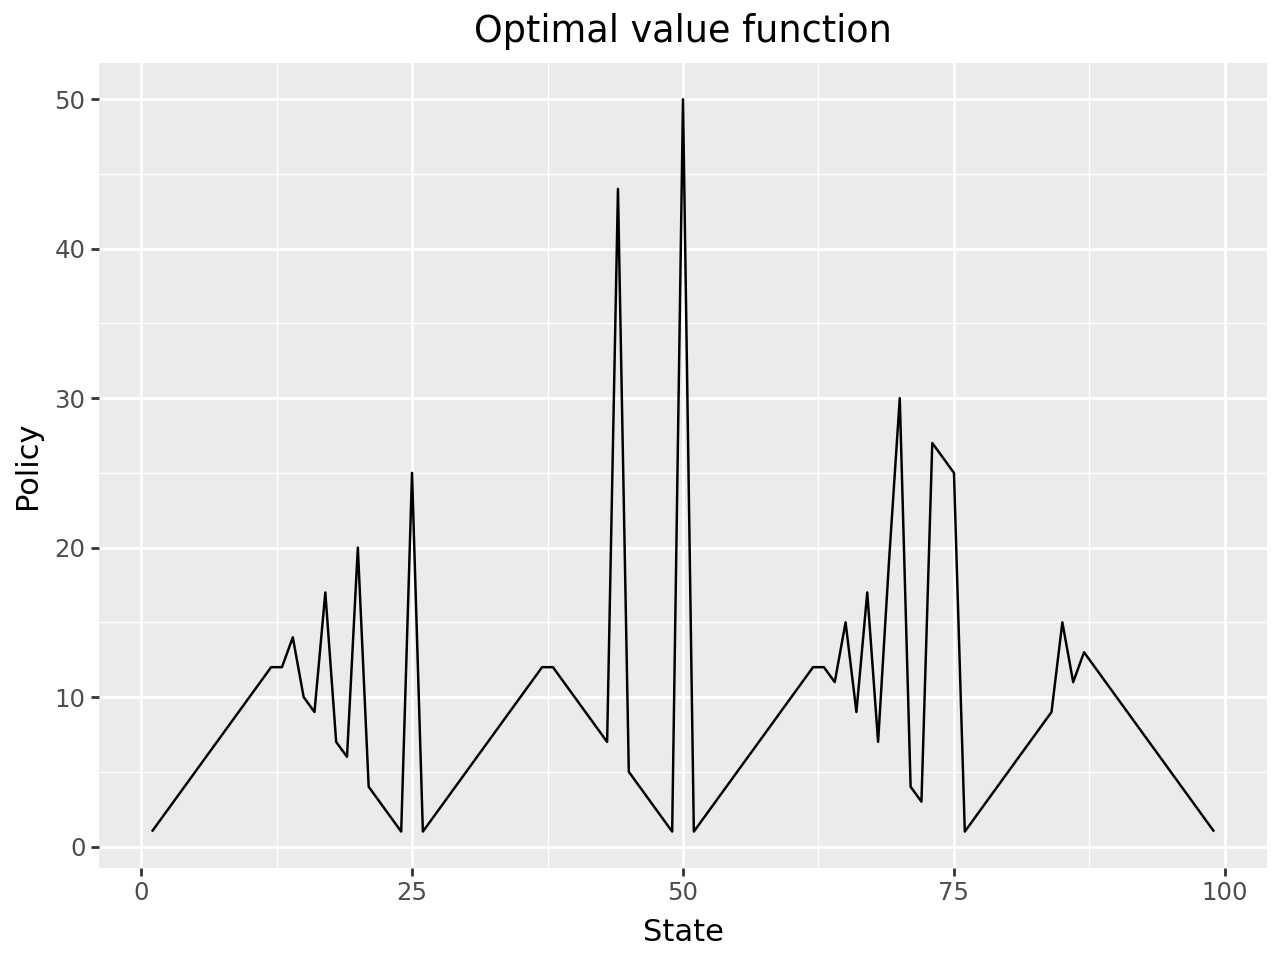

Probability of winning s = 52:
        Value
52  0.407746


In [27]:
#@title Solution (Q2)

from plotnine import *
from dfply import *

mdp.value_iteration(gamma=1)

df_result = (mdp.get_policy(add_state_values = True) >>
    rename(State = "state", Policy = "action", Value = "v") >>
    mutate(State = X.State.astype(int)))
display(df_result)

## Plots
df_result = df_result >> mask(X.State >= 1, X.State <= 99) >> mutate(Policy = X.Policy.astype(int))

# Plot the value function
pt = (
    ggplot(df_result, aes("State", "Value"))
    + geom_line()
    + theme(legend_position='bottom')
    + labs(title = "Optimal value function")
)
pt.show()

# Plot the policy function
pt = (
    ggplot(df_result, aes("State", "Policy"))
    + geom_line()
    + theme(legend_position='bottom')
    + labs(title = "Optimal value function")
)
pt.show()

print("Probability of winning s = 52:\n", df_result >> mask(X.State == 52) >> select(X.Value))

#### Q3

- Solve the problem using value iteration with $p_h = 0.25$ and $0.55$ and plot the state-values and the policy. What is the probability of winning in state 10 and 67?
- Assume that $p_h = 0.55$ and consider the policy to bet $\min(s, 100-s)$ in state $s\in\{1\ldots,99\}$. Plot the state-values and the policy.

In [ ]:
#@title Solution (Q3)

# Note using mdptoolbox as solver will not work here since the discount rate
# is 1, i.e. convergence is not guaranteed.

## p_h = 0.25
print("Results ph = 0.25:")
mdp = build_gambler_model(ph = 0.25)
mdp.value_iteration(1)
df_result = mdp.get_policy(add_state_values = True) >> mutate(state = X.state.astype(int), alg = "MDP")
df_result.set_index("state")
# display(df_result)
print("Probability of winning s = 10 (p_h = 0.25):", round(df_result.loc[10, 'v'],4))
print("Probability of winning s = 67 (p_h = 0.25):", round(df_result.loc[67, 'v'],4))

# Plots

df_result = df_result >> mask(X.state >= 1, X.state <= 99) >> mutate(action = X.action.astype(int))
pt = (
    ggplot(df_result, aes("state", "v", color = "alg"))
    + geom_line()
    + theme(legend_position='bottom')
    + labs(title = "Optimal value function")
)
pt.show()

pt = (
    ggplot(df_result, aes("state", "action"))
    + facet_grid(cols = "alg")
    + geom_col()
    + theme(legend_position='bottom')
    + labs(title = "Optimal policy")
)
pt.show()



## p_h = 0.55
___


## Fixed policy
print("Results fixed policy:")
policy = {str(s): str(min(s, 100-s)) for s in range(1, 100)}
policy.update({'0': 'Loose', '100': 'Win', '101': 'Dummy'})
mdp.set_deterministic_policy(policy)
mdp.policy_eval(1)
df_result = mdp.get_policy(add_state_values = True) >> mutate(state = X.state.astype(int), alg = "Pol")
df_result.set_index("state")

## Plots
___

#### Q4

Modify you code and calculate the expected total reward of all actions instead when $p_h = 0.25, 0.5$ and 0.75. Use the policy iteration algorithm. Note here action rewards are the expected reward given a bet. Why is the expected total reward highest for $p_h = 0.5$?

In [ ]:
#@title Solution (Q4)

# We update the function
def build_gambler_model(ph = 0.4, goal = 100, obj_eq_pr = True):
    ___
    return mdp

## Next, we define a function for plotting the results
def plot_results(ph):
    mdp = build_gambler_model(ph = ph, obj_eq_pr = False)
    mdp.value_iteration(1)
    df_result = mdp.get_policy(add_state_values = True) >> mutate(state = X.state.astype(int), alg = "MDP")
    df_result.set_index("state")

    # Plots
    df_result = df_result >> mask(X.state >= 1, X.state <= 99) >> mutate(action = X.action.astype(int))

    pt = (
        ggplot(df_result, aes("state", "v"))
        + geom_line()
        + theme(legend_position='bottom')
        + labs(title = "Optimal value function")
    )
    pt.show()

    pt = (
        ggplot(df_result, aes("state", "action"))
        + geom_col()
        + theme(legend_position='bottom')
        + labs(title = "Optimal policy")
    )
    pt.show()

    print("Expected total reward s = 50:", round(df_result.loc[50, 'v'],4))

print("Results p_h = 0.25")
plot_results(0.25)
print("\nResults p_h = 0.5")
plot_results(0.5)
print("\nResults p_h = 0.75")
plot_results(0.75)

# Reward depends on ...

### Exercise - Maintenance problem

Consider the [maintenance problem](https://bss-osca.github.io/rl/08_dp.html#sec-dp-maintain).

#### Q1


Define the state space $S$, i.e. the the set of possible states of the system.

<details>
<summary>Solution</summary>
$$S=\{1,2,\ \ldots,\ N,\ N+1\}.$$ State $s$ with $1\leq s\leq N$ corresponds to the situation in which an inspection reveals working condition $s$, while state $N+1$ corresponds to the situation in which an enforced repair is in progress already for one day.
</details>


#### Q2

Consider actions
$$
a=\left\{\begin{array}{ll}
0 & \text{if no repair.}\\
1 & \text{if preventive repair.}\\
2 & \text{if forced repair.}\\
\end{array}\right.
$$
Define the action space $A(s)$ for all states $s$.

<details>
<summary>Solution</summary>
   The set of possible actions in state $s$ is chosen as $$A(1)=\{0\},\ A(s)=\{0,1\} \text{ for } 1<s<N, A(N)=A(N+1)=\{2\}.$$
</details>

#### Q3

Assume that the number of possible working conditions equals $N=5$. What is the expected reward $r(s,a)$?

<details>
<summary>Solution</summary>
The expected reward is $r(N+1,2) = 0$ and for $0 < s < N$ is $r(s,0) = 0$, $r(s,1) = -C_{ps}$. Finally, $r(N,2) = -C_{f}$ and $r(N+1,2) = 0$.
</details>

#### Q4

4) What is the transition probabilities?

<details>
<summary>Solution</summary>
   The transition probabilities $p(s'|s,a)$: $$p(s'|s,0) = q_{ij}, \text{ for } 1 \leq s<N,$$ $$p(1|s,1) = 1 \text{ for } 1<s<N,$$ $$p(N+1|N,2) = p(1|N+1,2) =1,$$ and zero otherwise.
</details>

#### Q5

Make a drawing of the state-expanded hypergraph for stage $t$ and $t+1$ (just by hand).

#### Q6

The repair costs are given by $C_{f}=10,\ C_{p2}=7,\ C_{p3}=7$ and $C_{p4}=5$ and the deterioration probabilities $q_{ij}$ are given by matrix Q:

In [ ]:
import pandas as pd
import numpy as np

q_mat = np.array([
   [0.90, 0.10, 0, 0, 0],
   [0, 0.80, 0.10, 0.05, 0.05],
   [0, 0, 0.70, 0.10, 0.20],
   [0, 0, 0, 0.50, 0.50]
])
print(q_mat)
print("Note q_ij = q_mat[i-1, j-1], e.g. q_23 =", q_mat[1,2])

Build the MDP.

In [ ]:
#@title Solution (Q6)

conditions = q_mat.shape[1]  # N
costs_prev = (0,0,7,7,5,0,0)  # cost prev rep
action_labels = ['no rep', 'prev rep', 'forced rep']
mdp = MDP()
mdp.add_state_space(range(1, conditions + 2))

def actions(s):
    """
    Possible actions given state s.

    Args:
        s (int): Current state.

    Returns:
        list: List of possible actions.
    """
    i = int(s)
    if i == 1: return ["no rep"]
    if i > 1 and i < conditions: return ["no rep", "prev rep"]
    if i == conditions: return ["forced rep"]
    if i == conditions+1: return ["forced rep"]
    return None

## Add trans pr and rewards
for s in mdp.get_state_keys():
    i = int(s)
    for a in actions(s):
        if a == "no rep":
            rew = 0
            q_vec = q_mat[i-1, (i-1):] # values in state row and col from state
            pr = {str(key+i): val for key, val in enumerate(q_vec)}
        if a == "prev rep":
            rew = -costs_prev[i]
            pr = ___
        if a == 'forced rep' and i == conditions:
            ___
        if a == 'forced rep' and i == conditions + 1:
            ___
        mdp.add_action(s, a, rew, pr)
mdp.check()
mdp.get_mdp_info()

#### Q7

Find the optimal policy given a discount rate of $\gamma = 0.6$. What is the expected total discounted cost of being in state 3?

In [ ]:
#@title Solution (Q7)

mdp.v___
df_result = mdp.___
df_result.set_index("state", inplace = True)
display(df_result)
print("The expected total discounted cost in state 3 is:", -round(___,2))

#### Q8

Find the optimal policy using value iteration given a discount rate of $\gamma = 0.99$. Why do the algorithm need more iterations compared to when $\gamma = 0.6$? Why are the average discounted costs higher compared to when $\gamma = 0.6$? Is it more costly to use this optimal policy?

In [ ]:
#@title Solution (Q8)



### Exercise - Car rental problem

Consider the [car [rental](https://) problem](https://bss-osca.github.io/rl/07_mdp-2.html#sec-mdp-2-car). The reward can be coded using:

In [ ]:
import numpy as np
from scipy.stats import poisson

# Mean of min(D, z). Assume z >= 0
def mean_min_d(z, lambda_):
    """
    Compute the expected value of min(D, z) where D ~ Poisson(lambda).

    Args:
        z (int): Upper bound for the minimum (greater than 0).
        lam (float): Lambda for the Poisson distribution.

    Returns:
        float: Expected value of min(D, z)
    """
    if z == 0:
        return 0
    return np.sum(poisson.pmf(np.arange(z), lambda_) * np.arange(z)) + poisson.sf(z-1, lambda_) * z

# Reward function
def reward(x, y, a):
    """
    Compute the reward based on input parameters for the car rental problem.

    Args:
        x (int): Number of cars at location 1.
        y (int): Number of cars at location 2.
        a (int): Number of cars moved from location 1 to location 2 (negative means moved from 2 to 1).

    Returns:
        float: Calculated reward
    """
    return 10 * mean_min_d(x - a, 3) + 10 * mean_min_d(y + a, 4) - 2 * abs(a)

# Test the reward function
print(f'Reward given 20 cars at location 1, 0 cars at location 2, and 0 cars moved: {reward(20, 0, 0)}')
print(f'Reward given 20 cars at location 1, 0 cars at location 2, and 5 cars moved: {reward(20, 0, 5)}')

To find the transition probabilities $$ p((x',y') | (x,y), a) = p(x' | \bar{x} = x-a) p(y' | \bar{y} = y+a),$$ we need to calculate $p(x'| \bar{x})$ and $p(y'| \bar{y})$.

In [ ]:
def pr_min(i, k, d, lambda_demand = [3, 4], lambda_return = [3, 2]):
    """
    Compute the probability that min(D_i, k) = d (assuming d <= k)

    This is used to calculate the probability of the number of cars demanded or
    rented being less than or equal to the number of cars available or requested.

    Args:
        i (int): Index for the lambda value (0 for location 1 demand, 1 for location 2 demand,
                 2 for location 1 return, 3 for location 2 return).
        k (int): The upper cap value.
        d (int): The target minimum value.

    Returns:
        float: Probability that min(D_i, k) = d
    """
    if k == 0:
        return 1 if d == 0 else 0
    # Determine which lambda to use based on the index i
    if i == 0: # Location 1 demand
        lam = lambda_demand[0]
    elif i == 1: # Location 2 demand
        lam = lambda_demand[1]
    elif i == 2: # Location 1 return
        lam = lambda_return[0]
    elif i == 3: # Location 2 return
        lam = lambda_return[1]
    else:
        raise ValueError("Invalid index for lambda.")

    prob_dist = np.concatenate([poisson.pmf(np.arange(k), lam), [poisson.sf(k-1, lam)]])
    return prob_dist[d] if d < len(prob_dist) else 0


def trans_pr_x(x_next, x_bar):
    """
    Compute transition probability Pr(x_next | x_bar).

    This calculates the probability of the number of cars at location 1 transitioning
    to x_next given x_bar cars after the move and before return/return.

    Args:
        x_next (int): The number of cars at location 1 in the next state.
        x_bar (int): The number of cars at location 1 after the action (movement).

    Returns:
        float: Transition probability
    """
    prob = 0.0
    for d1_actual in range(x_bar + 1): # d1_actual is min(D1, x_bar)
        # Probability of min(D1, x_bar) being d1_actual
        pr_d1_actual = pr_min(0, x_bar, d1_actual) # Use index 0 for location 1 demand

        cars_after_demand1 = x_bar - d1_actual
        cars_can_return_to_loc1 = 20 - cars_after_demand1

        # The number of returns at location 1 is min(H1, cars_can_return_to_loc1)
        # The next state x_next = cars_after_demand1 + min(H1, cars_can_return_to_loc1)
        # So, min(H1, cars_can_return_to_loc1) = x_next - cars_after_demand1
        h1_actual = x_next - cars_after_demand1

        if h1_actual >= 0 and h1_actual <= cars_can_return_to_loc1:
             prob += pr_d1_actual * pr_min(2, cars_can_return_to_loc1, h1_actual) # Use index 2 for location 1 return

    return prob


def trans_pr_y(y_next, y_bar):
    """
    Compute transition probability Pr(y_next | y_bar).

    This calculates the probability of the number of cars at location 2 transitioning
    to y_next given y_bar cars after the move and before return/return.

    Args:
        y_next (int): The number of cars at location 2 in the next state.
        y_bar (int): The number of cars at location 2 after the action (movement).

    Returns:
        float: Transition probability
    """
    prob = 0.0
    for d2_actual in range(y_bar + 1): # d2_actual is min(D2, y_bar)
        # Probability of min(D2, y_bar) being d2_actual
        pr_d2_actual = pr_min(1, y_bar, d2_actual) # Use index 1 for location 2 demand

        cars_after_demand2 = y_bar - d2_actual
        cars_can_return_to_loc2 = 20 - cars_after_demand2

        # The number of returns at location 2 is min(H2, cars_can_return_to_loc2)
        # The next state y_next = cars_after_demand2 + min(H2, cars_can_return_to_loc2)
        # So, min(H2, cars_can_return_to_loc2) = y_next - cars_after_demand2
        h2_actual = y_next - cars_after_demand2

        if h2_actual >= 0 and h2_actual <= cars_can_return_to_loc2:
             prob += pr_d2_actual * pr_min(3, cars_can_return_to_loc2, h2_actual) # Use index 3 for location 2 return

    return prob

We can now store the values of $p(x'| \bar{x})$ and $p(y'| \bar{y})$ in two matrices (in the rows we have $\bar{x}$):

In [ ]:
# Initialize matrices
mat = np.zeros((21, 21))
mat_trans_pr_x = mat.copy()
mat_trans_pr_y = mat.copy()

# Populate the matrices
for r in range(21):
    x_bar = r
    for c in range(21):
        x_next = c
        mat_trans_pr_x[r, c] = trans_pr_x(x_next, x_bar)
        mat_trans_pr_y[r, c] = trans_pr_y(x_next, x_bar)

## Check if row sums are 1
print(np.sum(mat_trans_pr_x, axis=1))
print(np.sum(mat_trans_pr_y, axis=1))

Finally, we can define the transition function $$ p((x',y') | (x,y), a) = p(x' | \bar{x} = x-a) p(y' | \bar{y} = y+a):$$

In [ ]:
def trans_pr(x, y, x_next, y_next, a, mat_x = mat_trans_pr_x, mat_y = mat_trans_pr_y):
    """
    Compute the joint transition probability from state (x, y) to (x_next, y_next) given action a.

    Args:
        x (int): Number of cars at location 1 in the current state.
        y (int): Number of cars at location 2 in the current state.
        x_next (int): Number of cars at location 1 in the next state.
        y_next (int): Number of cars at location 2 in the next state.
        a (int): Number of cars moved from location 1 to location 2 (negative means moved from 2 to 1).

    Returns:
        float: The joint transition probability P((x_next, y_next) | (x, y), a).
    """
    x_bar = x - a
    y_bar = y + a
    return mat_x[x_bar, x_next] * mat_y[y_bar, y_next]

#### Q1

Build the model.

In [ ]:
#@title Solution

state_labels = [f'({x}, {y})' for x in range(21) for y in range(21) ]
mdp = MDP()
mdp.add_state_space(state_labels)

# Iterate through all states and actions to set up the MDP
for x in range(21):
    for y in range(21):
        s_l = f'({x}, {y})' # Current state label
        for a in range(-5, 6):
            a_l = str(a) # Action label
            x_bar = x - a # Cars at location 1 after move
            y_bar = y + a # Cars at location 2 after move

            # Check for illegal actions (moving more cars than available or exceeding capacity)
            if x_bar < 0 or y_bar < 0 or x_bar > 20 or y_bar > 20:
                continue

            # Calculate reward for the state-action pair
            rew = ___

            # Calculate transition probabilities to all possible next states (x_next, y_next)
            trans_probs = {}
            for x_next in range(21):
                for y_next in range(21):
                    pr = trans_pr(___)
                    if pr > 1e-16: # Only add non-negligible probabilities
                        trans_probs[f'({x_next}, {y_next})'] = ___

            # Set the action in the MDP builder
            mdp.add_action(___)
mdp.check()
mdp.get_mdp_info()

#### Q2

Solve the problem using policy iteration with a discount rate $\gamma = 0.5$.

- What is the optimal action in state $(1,15)$?
- What is the expected total discounted reward of being in state $(10,3)$?
- Make a plot of the optimal policy with $x$ on the y-axis and $y$ on the x-axis, plotting the action.

In [ ]:
#@title Solution

mdp.___
df_result = mdp.___
# display(df_result)

# Plot
df_result = (df_result
   >> separate(X.state, into = ["x", "y"], sep = ",", remove = False)
   >> separate(X.x, into = ["z", "x"], remove = False, convert = True)
   >> separate(X.y, into = ["z", "y"], remove = False, convert = True)
   >> select(~X.z)
)
# df_result
display(df_result >> mask((X.state == '(1, 15)') | (X.state == ___)))
# Optimal action in (1, 15) is to move 3 cars from loc 2 to 1
# The expected total discounted reward of being in state (10, 3) is approx 129.7.

pt = (
    ggplot(df_result, aes("x", "y", label = "action", color = "action"))
    + geom_label(size = 7)
    + theme(legend_position='none')
    + labs(title = "Optimal policy for gamma = 0.5")
)
pt.show()

#### Q3

Solve the problem using value iteration. Check if the policy and state-values are the same as in Question 2. If not why could this be okay?


In [ ]:
#@title Solution

___

#### Q4

Solve the problem using policy iteration with a discount rate $\gamma = 0.9$. Why are the state-values higher now?

In [ ]:
#@title Solution

___